# Assignment 4: Benchmarking Fashion-MNIST with Deep Neural Nets

### CS 4501 Machine Learning - Department of Computer Science - University of Virginia
"The original MNIST dataset contains a lot of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms. In fact, MNIST is often the first dataset researchers try. "If it doesn't work on MNIST, it won't work at all", they said. "Well, if it does work on MNIST, it may still fail on others." - **Zalando Research, Github Repo.**"

Fashion-MNIST is a dataset from the Zalando's article. Each example is a 28x28 grayscale image, associated with a label from 10 classes. They intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms.

![Here's an example how the data looks (each class takes three-rows):](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

In this assignment, you will attempt to benchmark the Fashion-MNIST using Neural Networks. You must use it to train some neural networks on TensorFlow and predict the final output of 10 classes. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.


In [0]:
# You might want to use the following packages
import numpy as np
import os
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR) #reduce annoying warning messages
from functools import partial

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


---
## 1. PRE-PROCESSING THE DATA (10 pts)

You can load the Fashion MNIST directly from Tensorflow. **Partition of the dataset** so that you will have 50,000 examples for training, 10,000 examples for validation, and 10,000 examples for testing. Also, make sure that you platten out each of examples so that it contains only a 1-D feature vector.

Write some code to output the dimensionalities of each partition (train, validation, and test sets).



In [0]:
# Your code goes here for this section.
fmnist = tf.keras.datasets.fashion_mnist.load_data();


In [0]:
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test)=fmnist
X_train, X_valid, y_train, y_valid=train_test_split( X_train, y_train, test_size=1/6, random_state=42)

In [26]:

print("The shape of train_images is ",X_train.shape)
print("The shape of train_labels is ",y_train.shape)
print("The shape of test_images is ",X_test.shape)
print("The shape of test_labels is ",y_test.shape)
print("The shape of validation_images is ",X_valid.shape)
print("The shape of validation_labels is ",y_valid.shape)

The shape of train_images is  (50000, 28, 28)
The shape of train_labels is  (50000,)
The shape of test_images is  (10000, 28, 28)
The shape of test_labels is  (10000,)
The shape of validation_images is  (10000, 28, 28)
The shape of validation_labels is  (10000,)


In [0]:
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
X_valid = X_valid.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_valid = y_valid.astype(np.int32)

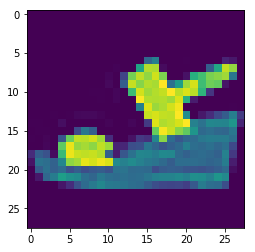

In [28]:
import matplotlib.pyplot as plt
image=X_train[55,:].reshape(28,28)
plt.imshow(image)
plt.show()


- - -
## 2. CONSTRUCTION PHASE (30 pts)

In this section, define at least three neural networks with different structures. Make sure that the input layer has the right number of inputs. The best structure often is found through a process of trial and error experimentation:
- You may start with a fully connected network structure with two hidden layers.
- You may try a few settings of the number of nodes in each layer.
- You may try a few activation functions to see if they affect the performance.

**Important Implementation Note:** For the purpose of learning Tensorflow, you must use low-level TensorFlow API to construct the network. Usage of high-level tools (ie. Keras) is not permited. 

In [0]:
# Your code goes here
reset_graph()

# Set some configuration here
n_inputs = 28*28  # Fashion-MNIST
learning_rate = 0.01
n_outputs = 10


# Construct placeholder for the input layer
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
#add n_outputs by myself
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

In [0]:
with tf.name_scope("dnn1"):
  #implementation of the first net here
#     dnn1_hidden1 = 500
#     dnn1_hidden2 = 250
    dnn1_hidden1 = 400
    dnn1_hidden2 = 200
    hidden1 = tf.layers.dense(X, dnn1_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, dnn1_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [0]:
with tf.name_scope("loss"):
#implementation of the loss function net here
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
  loss = tf.reduce_mean(xentropy, name="loss")

In [0]:
with tf.name_scope("train"):
  #implementation of the training optimizer here
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [0]:
with tf.name_scope("eval"):
  correct = tf.nn.in_top_k(logits, y, 1)
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

- - -
## 3. EXECUTION PHASE (30 pts)

After you construct the three models of neural networks, you can compute the performance measure as the class accuracy. You will need to define the number of epochs and size of the training batch. You also might need to reset the graph each time your try a different model. To save time and avoid retraining, you should save the trained model and load it from disk to evaluate a test set. Pick the best model and answer the following:
- Which model yields the best performance measure for your dataset? Provide a reason why it yields the best performance.
- Why did you pick this many hidden layers?
- Provide some justifiable reasons for selecting the number of neurons per hidden layers. 
- Which activation functions did you use?

In the next session you will get a chance to finetune it further .



## Comment: I reorder the codes for each dnn I construct.

In [0]:
# Your code goes here
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs =70 
batch_size = 50

# shuffle_batch() shuffle the examples in a batch before training
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch


In [14]:
with tf.Session() as sess:
  print("results for DNN1")
  init.run()
  for epoch in range(n_epochs):
    # implementation of the training ops here
    # implementation of the validation accuracy here
    for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    if epoch % 5 == 0:
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
    
  save_path = saver.save(sess, "./my_dnn_model.ckpt")

results for DNN1
0 Batch accuracy: 0.8 Validation accuracy: 0.8008
5 Batch accuracy: 0.86 Validation accuracy: 0.8547
10 Batch accuracy: 0.94 Validation accuracy: 0.8691
15 Batch accuracy: 0.86 Validation accuracy: 0.8756
20 Batch accuracy: 0.9 Validation accuracy: 0.8806
25 Batch accuracy: 0.96 Validation accuracy: 0.8788
30 Batch accuracy: 0.94 Validation accuracy: 0.8834
35 Batch accuracy: 0.9 Validation accuracy: 0.8856
40 Batch accuracy: 0.92 Validation accuracy: 0.8885
45 Batch accuracy: 0.96 Validation accuracy: 0.8881
50 Batch accuracy: 0.98 Validation accuracy: 0.8883
55 Batch accuracy: 0.92 Validation accuracy: 0.8911
60 Batch accuracy: 0.98 Validation accuracy: 0.8887
65 Batch accuracy: 0.96 Validation accuracy: 0.882


In [15]:
with tf.Session() as sess:
    saver.restore(sess, "./my_dnn_model.ckpt")
    # implementation of the test set evaluation here
    for epoch in range(n_epochs):
      if epoch % 10 == 0:
          acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
          print(epoch, "Test accuracy:", acc_test)

0 Test accuracy: 0.88
10 Test accuracy: 0.88
20 Test accuracy: 0.88
30 Test accuracy: 0.88
40 Test accuracy: 0.88
50 Test accuracy: 0.88
60 Test accuracy: 0.88


In [16]:
# print out the final accuracy here
 print("Final test accuracy: {:.2f}%".format(acc_test * 100))

Final test accuracy: 88.00%


## Dnn2

In [17]:

reset_graph()

# Set some configuration here
n_inputs = 28*28  # Fashion-MNIST
learning_rate = 0.01
n_outputs = 10


# Construct placeholder for the input layer
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
#add n_outputs by myself
y = tf.placeholder(tf.int32, shape=(None), name="y")


with tf.name_scope("dnn2"):
  #implementation of the second net here
#     dnn2_hidden1 = 500
#     dnn2_hidden2 = 250
#     dnn2_hidden3 = 130
#     dnn2_hidden4 = 70
    dnn2_hidden1 = 400
    dnn2_hidden2 = 200
    dnn2_hidden3 = 100
    dnn2_hidden4 = 50
    dnn2_outputs=10
    hidden1_2 = tf.layers.dense(X, dnn2_hidden1, activation=tf.nn.elu, name="hidden1_2")
    hidden2_2 = tf.layers.dense(hidden1_2, dnn2_hidden2, activation=tf.nn.elu, name="hidden2_2")
    hidden3_2 = tf.layers.dense(hidden2_2, dnn2_hidden3, activation=tf.nn.elu, name="hidden3_2")
    hidden4_2 = tf.layers.dense(hidden3_2, dnn2_hidden4, activation=tf.nn.elu, name="hidden4_2")
    logits2 = tf.layers.dense(hidden4_2, dnn2_outputs, name="dnn2_outputs")
    

with tf.name_scope("loss"):
#implementation of the loss function net here
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits2)
  loss = tf.reduce_mean(xentropy, name="loss")
  
with tf.name_scope("train"):
  #implementation of the training optimizer here
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
  correct = tf.nn.in_top_k(logits2, y, 1)
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
  
  
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs =70 
batch_size = 50

# shuffle_batch() shuffle the examples in a batch before training
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        
with tf.Session() as sess:
  print("results for DNN2")
  init.run()
  for epoch in range(n_epochs):
    # implementation of the training ops here
    # implementation of the validation accuracy here
    for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    if epoch % 5 == 0:
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
    
  save_path = saver.save(sess, "./my_dnn_model.ckpt")
  
with tf.Session() as sess:
    saver.restore(sess, "./my_dnn_model.ckpt")
    # implementation of the test set evaluation here
    for epoch in range(n_epochs):
      if epoch % 10 == 0:
          acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
          print(epoch, "Test accuracy:", acc_test)
          
          
# print out the final accuracy here
print("Final test accuracy: {:.2f}%".format(acc_test * 100))

results for DNN2
0 Batch accuracy: 0.84 Validation accuracy: 0.8121
5 Batch accuracy: 0.88 Validation accuracy: 0.8545
10 Batch accuracy: 0.94 Validation accuracy: 0.8682
15 Batch accuracy: 0.9 Validation accuracy: 0.8784
20 Batch accuracy: 0.9 Validation accuracy: 0.8811
25 Batch accuracy: 0.98 Validation accuracy: 0.8797
30 Batch accuracy: 0.94 Validation accuracy: 0.8859
35 Batch accuracy: 0.88 Validation accuracy: 0.8858
40 Batch accuracy: 0.86 Validation accuracy: 0.8864
45 Batch accuracy: 0.98 Validation accuracy: 0.8881
50 Batch accuracy: 0.96 Validation accuracy: 0.8887
55 Batch accuracy: 0.9 Validation accuracy: 0.8882
60 Batch accuracy: 1.0 Validation accuracy: 0.889
65 Batch accuracy: 0.96 Validation accuracy: 0.8819
0 Test accuracy: 0.8832
10 Test accuracy: 0.8832
20 Test accuracy: 0.8832
30 Test accuracy: 0.8832
40 Test accuracy: 0.8832
50 Test accuracy: 0.8832
60 Test accuracy: 0.8832
Final test accuracy: 88.32%


## DNN 3

In [18]:
reset_graph()

# Set some configuration here
n_inputs = 28*28  # Fashion-MNIST
learning_rate = 0.01


# Construct placeholder for the input layer
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
#add n_outputs by myself
y = tf.placeholder(tf.int32, shape=(None), name="y")


with tf.name_scope("dnn3"):
  #implementation of the second net here
#     dnn3_hidden1 = 500
#     dnn3_hidden2 = 250
#     dnn3_hidden3 = 130
#     dnn3_outputs=10
    dnn3_hidden1 = 400
    dnn3_hidden2 = 200
    dnn3_hidden3 = 100
    dnn3_outputs=10
    hidden1_3 = tf.layers.dense(X, dnn3_hidden1, activation=tf.nn.elu, name="hidden1_3")
    hidden2_3 = tf.layers.dense(hidden1_3, dnn3_hidden2, activation=tf.nn.elu, name="hidden2_3")
    hidden3_3 = tf.layers.dense(hidden2_3, dnn3_hidden3, activation=tf.nn.elu, name="hidden3_3")
    logits3 = tf.layers.dense(hidden3_3, dnn3_outputs, name="dnn3_outputs")
    

with tf.name_scope("loss"):
#implementation of the loss function net here
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits3)
  loss = tf.reduce_mean(xentropy, name="loss")
  
with tf.name_scope("train"):
  #implementation of the training optimizer here
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
  correct = tf.nn.in_top_k(logits3, y, 1)
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
  
  
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs =70 
batch_size = 50

# shuffle_batch() shuffle the examples in a batch before training
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        
with tf.Session() as sess:
  print("results for DNN3")
  init.run()
  for epoch in range(n_epochs):
    # implementation of the training ops here
    # implementation of the validation accuracy here
    for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    if epoch % 5 == 0:
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
    
  save_path = saver.save(sess, "./my_dnn_model.ckpt")
  
with tf.Session() as sess:
    saver.restore(sess, "./my_dnn_model.ckpt")
    # implementation of the test set evaluation here
    for epoch in range(n_epochs):
      if epoch % 10 == 0:
          acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
          print(epoch, "Test accuracy:", acc_test)
          
          
# print out the final accuracy here
print("Final test accuracy: {:.2f}%".format(acc_test * 100))

results for DNN3
0 Batch accuracy: 0.8 Validation accuracy: 0.8162
5 Batch accuracy: 0.86 Validation accuracy: 0.8521
10 Batch accuracy: 0.92 Validation accuracy: 0.866
15 Batch accuracy: 0.86 Validation accuracy: 0.8752
20 Batch accuracy: 0.88 Validation accuracy: 0.8789
25 Batch accuracy: 0.96 Validation accuracy: 0.8765
30 Batch accuracy: 0.92 Validation accuracy: 0.8821
35 Batch accuracy: 0.88 Validation accuracy: 0.8834
40 Batch accuracy: 0.9 Validation accuracy: 0.8853
45 Batch accuracy: 0.96 Validation accuracy: 0.8897
50 Batch accuracy: 0.98 Validation accuracy: 0.8875
55 Batch accuracy: 0.9 Validation accuracy: 0.891
60 Batch accuracy: 0.96 Validation accuracy: 0.8876
65 Batch accuracy: 0.96 Validation accuracy: 0.8797
0 Test accuracy: 0.8814
10 Test accuracy: 0.8814
20 Test accuracy: 0.8814
30 Test accuracy: 0.8814
40 Test accuracy: 0.8814
50 Test accuracy: 0.8814
60 Test accuracy: 0.8814
Final test accuracy: 88.14%


## DNN 4

In [19]:
reset_graph()

# Set some configuration here
n_inputs = 28*28  # Fashion-MNIST
learning_rate = 0.01


# Construct placeholder for the input layer
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
#add n_outputs by myself
y = tf.placeholder(tf.int32, shape=(None), name="y")


with tf.name_scope("dnn4"):
  #implementation of the second net here
#     dnn4_hidden1 = 500
#     dnn4_hidden2 = 250
#     dnn4_hidden3 = 130
#     dnn4_hidden4 = 70
#     dnn4_hidden5 = 40
    dnn4_hidden1 = 400
    dnn4_hidden2 = 1
    dnn4_hidden3 = 100
    dnn4_hidden4 = 50
    dnn4_hidden5 = 20
    dnn4_outputs=10
    hidden1_4 = tf.layers.dense(X, dnn4_hidden1, activation=tf.nn.elu, name="hidden1_4")
    hidden2_4 = tf.layers.dense(hidden1_4, dnn4_hidden2, activation=tf.nn.elu, name="hidden2_4")
    hidden3_4 = tf.layers.dense(hidden2_4, dnn4_hidden3, activation=tf.nn.elu, name="hidden3_4")
    hidden4_4 = tf.layers.dense(hidden3_4, dnn4_hidden4, activation=tf.nn.elu, name="hidden4_4")
    hidden5_4 = tf.layers.dense(hidden4_4, dnn4_hidden5, activation=tf.nn.elu, name="hidden5_4")
                                 
    logits4 = tf.layers.dense(hidden5_4, dnn4_outputs, name="dnn4_outputs")
    

with tf.name_scope("loss"):
#implementation of the loss function net here
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits4)
  loss = tf.reduce_mean(xentropy, name="loss")
  
with tf.name_scope("train"):
  #implementation of the training optimizer here
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
  correct = tf.nn.in_top_k(logits4, y, 1)
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
  
  
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs =70 
batch_size = 50

# shuffle_batch() shuffle the examples in a batch before training
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        
with tf.Session() as sess:
  print("results for DNN4")
  init.run()
  for epoch in range(n_epochs):
    # implementation of the training ops here
    # implementation of the validation accuracy here
    for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    if epoch % 5 == 0:
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
    
  save_path = saver.save(sess, "./my_dnn_model.ckpt")
  
with tf.Session() as sess:
    saver.restore(sess, "./my_dnn_model.ckpt")
    # implementation of the test set evaluation here
    for epoch in range(n_epochs):
      if epoch % 10 == 0:
          acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
          print(epoch, "Test accuracy:", acc_test)
          
          
# print out the final accuracy here
print("Final test accuracy: {:.2f}%".format(acc_test * 100))

results for DNN4
0 Batch accuracy: 0.84 Validation accuracy: 0.7944
5 Batch accuracy: 0.88 Validation accuracy: 0.857
10 Batch accuracy: 0.94 Validation accuracy: 0.8713
15 Batch accuracy: 0.88 Validation accuracy: 0.8827
20 Batch accuracy: 0.94 Validation accuracy: 0.8851
25 Batch accuracy: 0.96 Validation accuracy: 0.8822
30 Batch accuracy: 0.94 Validation accuracy: 0.8824
35 Batch accuracy: 0.92 Validation accuracy: 0.8882
40 Batch accuracy: 0.9 Validation accuracy: 0.887
45 Batch accuracy: 1.0 Validation accuracy: 0.8891
50 Batch accuracy: 1.0 Validation accuracy: 0.8866
55 Batch accuracy: 0.94 Validation accuracy: 0.8873
60 Batch accuracy: 0.98 Validation accuracy: 0.8875
65 Batch accuracy: 1.0 Validation accuracy: 0.8851
0 Test accuracy: 0.8793
10 Test accuracy: 0.8793
20 Test accuracy: 0.8793
30 Test accuracy: 0.8793
40 Test accuracy: 0.8793
50 Test accuracy: 0.8793
60 Test accuracy: 0.8793
Final test accuracy: 87.93%


My second model with dnn2 performs best since it yields the highest accuracy of 88.32% of the three models I construct. I pick four hidden layers since I have tried two, three, four and five hidden layers. The accuracy rate increases as I add hidden layers from two to four, but it decreases as I add the fifth layer. I decrease the number of neurons by approximately 50%  for each additional layers. For instance, I use 400 neurons for my first layer, 200 neurons for my second layer, 100 for the third and 50 for the fourth. I use elu function for this model. 

- - -
## 4. FINETUNING THE NETWORK (25 pts)

The best performance on the Fashion MNIST of a non-neural-net classifier is the Support Vector Classifier {"C":10,"kernel":"poly"} with 0.897 accuracy. In this section, you will see how close you can get to that accuracy, or (better yet) beat it! You will be able to see the performance of other ML methods below:
http://fashion-mnist.s3-website.eu-central-1.amazonaws.com

Use the best model from the previous section and see if you can improve it further. To improve the performance of your model, You must make some modifications based upon the practical guidelines discuss in class. Here are a few decisions about the recommended network configurations you have to make:
1. Initialization: Use He Initialization for your model
2. Activation: Add ELU as the activation function throughout your hidden layers
3. Normalization: Incorporate the batch normalization at every layer
4. Regularization: Configure the dropout policy at 50% rate
5. Optimization: Change Gradient Descent into Adam Optimization
6. Your choice: make any other changes in 1-5 you deem necessary

Keep in mind that the execution phase is essentially the same, so you can just run it from the above. See how much you gain in classification accuracy. Provide some justifications for the gain in performance. 






In [0]:
reset_graph()

# Set some configuration here
n_inputs = 28*28  # Fashion-MNIST
learning_rate = 0.01

batch_norm_momentum = 0.9
training = tf.placeholder_with_default(False, shape=(), name='training')

# Construct placeholder for the input layer
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
#add n_outputs by myself
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnnBenchmark"):
   # implementation of the new benchmarking DNN here
    #He Initialization 
    he_init = tf.variance_scaling_initializer()
    
#     dnnB_hidden1 = 500
#     dnnB_hidden2 = 250
#     dnnB_hidden3 = 130
#     dnnB_hidden4 = 70
    dnnB_hidden1 = 400
    dnnB_hidden2 = 200
    dnnB_hidden3 = 100
    dnnB_hidden4 = 50
    dnnB_outputs=10
    #Batch normalization && dropout
    training = tf.placeholder_with_default(False, shape=(), name='training')
    hidden1_B = tf.layers.dense(X_drop, dnnB_hidden1, name="hidden1_B")
    bn1 = tf.layers.batch_normalization(hidden1_B, training=training, momentum=batch_norm_momentum)
    bn1_act = tf.nn.elu(bn1)
    bn1_dp = tf.layers.dropout(bn1_act, dropout_rate, training=training)
    hidden2_B = tf.layers.dense(bn1_dp, dnnB_hidden2, name="hidden2_B")
    bn2 = tf.layers.batch_normalization(hidden2_B, training=training, momentum=batch_norm_momentum)
    bn2_act = tf.nn.elu(bn2)
    bn2_dp = tf.layers.dropout(bn2_act, dropout_rate, training=training)
   
  
    hidden3_B = tf.layers.dense(bn2_dp, dnnB_hidden3, name="hidden3_B")
    bn3 = tf.layers.batch_normalization(hidden3_B, training=training, momentum=batch_norm_momentum)
    bn3_act = tf.nn.elu(bn3)
    bn3_dp = tf.layers.dropout(bn3_act, dropout_rate, training=training)
    
    
    hidden4_B = tf.layers.dense(bn3_dp, dnnB_hidden4, name="hidden4_B")
    bn4 = tf.layers.batch_normalization(hidden2_B, training=training, momentum=batch_norm_momentum)
    bn4_act = tf.nn.elu(bn4)
    bn4_dp = tf.layers.dropout(bn4_act, dropout_rate, training=training)
  
    logits_before_bn = tf.layers.dense(bn4_dp, dnnB_outputs, name="dnnB_outputs") 
#     logits_before_bn = tf.layers.dense(bn2_dp, dnnB_outputs, name="dnnB_outputs")
    logitsB = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)
    

In [94]:
with tf.name_scope("loss"):
#implementation of the loss function net here
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logitsB)
  loss = tf.reduce_mean(xentropy, name="loss")
  
with tf.name_scope("train"):
  #implementation of the training optimizer here
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
  correct = tf.nn.in_top_k(logitsB, y, 1)
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
  
  
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs =50
batch_size =70

# shuffle_batch() shuffle the examples in a batch before training
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        
with tf.Session() as sess:
  print("results for Dnn Benchmark")
  init.run()
  for epoch in range(n_epochs):
    # implementation of the validation accuracy here
    for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    if epoch % 5 == 0:
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
    
  save_path = saver.save(sess, "./my_dnn_model.ckpt")
  
with tf.Session() as sess:
    saver.restore(sess, "./my_dnn_model.ckpt")
    # implementation of the test set evaluation here
    for epoch in range(n_epochs):
      if epoch % 10 == 0:
          acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
          print(epoch, "Test accuracy:", acc_test)
          
          
# print out the final accuracy here
print("Final test accuracy: {:.2f}%".format(acc_test * 100))

results for Dnn Benchmark
0 Batch accuracy: 0.8142857 Validation accuracy: 0.83
5 Batch accuracy: 0.87142855 Validation accuracy: 0.8738
10 Batch accuracy: 0.9714286 Validation accuracy: 0.8835
15 Batch accuracy: 0.9 Validation accuracy: 0.8849
20 Batch accuracy: 0.95714283 Validation accuracy: 0.8893
25 Batch accuracy: 0.98571426 Validation accuracy: 0.8847
30 Batch accuracy: 0.94285715 Validation accuracy: 0.8913
35 Batch accuracy: 0.9285714 Validation accuracy: 0.8872
40 Batch accuracy: 0.8857143 Validation accuracy: 0.8939
45 Batch accuracy: 1.0 Validation accuracy: 0.8891
0 Test accuracy: 0.8899
10 Test accuracy: 0.8899
20 Test accuracy: 0.8899
30 Test accuracy: 0.8899
40 Test accuracy: 0.8899
Final test accuracy: 88.99%


how much you gain in classification accuracy. Provide some justifications for the gain in performance.

My DNN benchmark model has an accuracy of 88.99%, which increases accuracy by 0.67% compared to the best model I got from the last section, the dnn2 model with an accuracy of 88.32%. I think the reason why my performance becomes better is that I add He initialization, batch normalization and change Gradient Decent into Adma optimization. I also change my batch size from 50 to 70 and decrease my iterations from 70 to 50. 

- - -
## 5. OUTLOOK (5 pts)

Plan for the outlook of your system: This may lead to the direction of your future project:
- Did your neural network outperform other "traditional ML technique? Why/why not?
- Does your model work well? If not, which model should be further investigated?
- Do you satisfy with your system? What do you think needed to improve?



My neural network outperforms most of other traditional ML techniques since the accuracy rate of my model is higher than all other models except SVC. I think my model is good and can work better with more experiments. Due to the limited computing power, it takes me a long time to run a model, so I dont't have time to try many different parameters. I think I would do more research on the rules to decided the number of nodes of each hidden layers and try more combinations. I will have a better and more specific learning schedule so that the results can be more closed the optimal points. Also, I may try different dropout rate or momentum to see whether it will improve the performance. Furthermore, I'd like to investigate convolutional neural network models.

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during OH
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4501 Assignment 4:...".
 * More on the Fashion-MNIST to be found here: https://hanxiao.github.io/2018/09/28/Fashion-MNIST-Year-In-Review/

Best of luck and have fun!